# glm-4 is all you need

在这个notebook中，我将带你使用GLM4来优化你的RAG程序。
1. 对于给定的知识库和你的问题（甚至可以没有问题），我们都可以使用GLM4来构建完整的问答、评估、标注、迭代过程。
2. 你还可以使用GLM4去生成问题、去提炼你的分片段落、去改写强化你的问题、去捕捉多轮对话中的深层次意图

你可以使用GLM4做到几乎全部的事情，哦，没有几乎

# 1. 向量模型

## 本地向量模型

In [1]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
from tqdm import tqdm_notebook as tqdm

model_name = "BAAI/bge-large-zh-v1.5"
# 根据你的需要去选择设备
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity
model = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
    query_instruction="为这个句子生成表示以用于检索相关文章："
)
model.query_instruction = "为这个句子生成表示以用于检索相关文章："

# 2. ZhipuAI调用Helper函数

In [4]:
# 请安装2.0.1版本 `pip install zhipuai==2.0.1`
from zhipuai import ZhipuAI


client = ZhipuAI(api_key="<your api_token>") # 填写您自己的APIKey

def ask_glm4(system_prompt, prompt):
    response = client.chat.completions.create(
        model="glm-4",  # 填写需要调用的模型名称
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt}
        ],
        temperature=0.1,
    )
    
    for k, v in json.loads(response.usage.model_dump_json()).items():
        if k not in tokens_counter:
            tokens_counter[k] = 0
        tokens_counter[k] += v
        
    return response.choices[0].message.content


tokens_counter = {}

# 3. 数据预览

## 知识文件

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
import json

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

In [6]:
data = open("rag-data/西游记.txt", encoding="utf-8").read()

In [7]:
print(data[:300])

《》目录 第一回　灵根育孕源流出　心性修持大道生
 
    诗曰：
 
    混沌未分天地乱，茫茫渺渺无人见。
 
    自从盘古破鸿蒙，开辟从兹清浊辨。
 
    覆载群生仰至仁，发明万物皆成善。
 
    欲知造化会元功，须看西游释厄传。
 
    盖闻天地之数，有十二万九千六百岁为一元。将一元分为十二会，乃子、丑、寅、卯、辰、巳、午、未、申、酉、戌、亥之十二支也。每会该一万八百岁。且就一日而论：子时得阳气，而丑则鸡鸣；寅不通光，而卯则日出；辰时食后，而巳则挨排；日午天中，而未则西蹉；申时晡而日落酉；戌黄昏而人定亥。譬于大数，若到戌会之终，则天地昏蒙而万物否矣。再去五千四百岁，


In [8]:
docs = text_splitter.create_documents([data])

In [9]:
len(docs)

2137

In [10]:
from tqdm.notebook import tqdm


def encode_with_progress_bar(docs, model, bs=256):
    from langchain_community.vectorstores import FAISS
    db = FAISS.from_documents(docs[:bs], embedding=model)
    for i in tqdm(range(bs, len(docs), bs), desc="enocde docs..."):
        db.add_documents(docs[i: i + bs])
    return db

In [ ]:
db = encode_with_progress_bar(docs, model=model)

enocde docs...:   0%|          | 0/8 [00:00<?, ?it/s]

In [10]:
db.similarity_search("为什么取名孙悟空?")

[Document(page_content='中有十二个字，分派起名到你乃第十辈之小徒矣。”猴王道：“那十二个字？”祖师道：“乃广、大、智、慧、真、如、性、海、颖、悟、圆、觉十二字。排到你，正当‘悟’字。与你起个法名叫做‘孙悟空’好么？”猴王笑道：“好！好！好！自今就叫做孙悟空也！”正是：鸿蒙初辟原无姓，打破顽空须悟空。'),
 Document(page_content='祖师道：“既是逐渐行来的也罢。你姓甚么？”猴王又道：“我无性。人若骂我，我也不恼；若打我，我也不嗔，只是陪个礼儿就罢了。一生无性。”祖师道：“不是这个性。你父母原来姓甚么？”猴王道：“我也无父母。”祖师道：“既无父母，想是树上生的？”猴王道：“我虽不是树生，却是石里长的。我只记得花果山上有一块仙石，其年石破，我便生也。”祖师闻言，暗喜道：“这等说，却是天地生成的。你起来走走我看。”猴王纵身跳起，拐呀拐的走了两遍。祖师笑道：“你身躯虽是鄙陋，却像个食松果的猢狲。我与你就身上取个姓氏，意思教你姓‘猢’。猢字去了个兽傍，乃是古月。古者，老也；月者，阴也。老阴不能化育，教你姓‘狲’倒好。狲字去了兽傍，乃是个子系。子者，儿男也；系者，婴细也。正合婴儿之本论。教你姓‘孙’罢。”猴王听说，满心欢喜，朝上叩头道：“好！好！好！今日方知姓也。万望师父慈悲！既然有姓，再乞赐个名字，却好呼唤。”祖师道：“我门中有十二个字，分派起名到你乃第十辈之小徒矣。”猴王道：“那十二个字？”祖师道：“乃广、大、智、慧、真、如、性、海、颖、悟、圆、觉十二字。排到你，正当‘悟’字。与你起个法名叫做‘孙悟空’好么？”猴王笑道'),
 Document(page_content='人心生一念，天地尽皆知。善恶若无报，乾坤必有私。\n \n    那菩萨闻得此言，满心欢喜，对大圣道：“圣经云：‘出其言善。\n \n    则千里之外应之；出其言不善，则千里之外适之。’你既有此心，待我到了东土大唐国寻一个取经的人来，教他救你。你可跟他做个徒弟，秉教伽持，入我佛门。再修正果，如何？”大圣声声道：“愿去！愿去！”菩萨道：“既有善果，我与你起个法名。”大圣道：“我已有名了，叫做孙悟空。”菩萨又喜道：“我前面也有二人归降，正是‘悟’字排行。你今也是‘悟’字，却与他相合，甚好，甚好。这等也不消叮嘱，我去也。”那大圣见性明心归佛教，这菩萨留情在意访神谱

In [11]:
db.save_local("xiyouji_vec_store_v1")

# 4. 问答数据

In [12]:
qa_100 = open("rag-data/xiyouji_qa_100.txt", encoding="utf-8").read()

In [13]:
qa_100.split("\n\n")[:5]

['1、 石猴出生于 东胜瀛洲傲来国花果山',
 '2、 为什么取名孙悟空?因为是猢狲，取姓为孙，排行第十为悟，取名为悟空',
 '3、 孙悟空从祖师那里学会了哪些本领?长生之道，七十二变和筋斗云',
 '4、 被祖师赶走时，不许他说什么?不许他说是祖师的徒弟',
 '5、 孙悟空的兵器叫什么?有多重?叫金箍如意棒，重一万三千五百斤']

In [14]:
import re
qa_lines = re.split("\d+", qa_100)

In [15]:
qa_lines[:10]

['',
 '、 石猴出生于 东胜瀛洲傲来国花果山\n\n',
 '、 为什么取名孙悟空?因为是猢狲，取姓为孙，排行第十为悟，取名为悟空\n\n',
 '、 孙悟空从祖师那里学会了哪些本领?长生之道，七十二变和筋斗云\n\n',
 '、 被祖师赶走时，不许他说什么?不许他说是祖师的徒弟\n\n',
 '、 孙悟空的兵器叫什么?有多重?叫金箍如意棒，重一万三千五百斤\n\n',
 '、 这兵器原有什么作用?是大禹治水是定江海深浅的定子\n\n',
 '、 弼马温是什么工作?养马\n\n',
 '、 孙悟空在大闹天宫，做了哪些事?偷吃蟠桃，偷吃御酒，偷吃老君仙丹\n\n',
 '、 为什么大闹天宫?因为蟠桃会没有请他\n\n']

In [16]:
def is_chinese_char(char):
    # 检查字符是否在常见的汉字Unicode范围内
    return '\u4E00' <= char <= '\u9FFF' or \
           '\u3400' <= char <= '\u4DBF' or \
           '\u20000' <= char <= '\u2A6DF' or \
           '\u2A700' <= char <= '\u2B73F' or \
           '\u2B740' <= char <= '\u2B81F' or \
           '\u2B820' <= char <= '\u2CEAF' or \
           '\u2F800' <= char <= '\u2FA1F'

def clean_text(text):
    for i in range(len(text)):
        if is_chinese_char(text[i]):
            return text[i:].strip()

In [17]:
qa_lines = [clean_text(text) for text in qa_lines if text]

In [18]:
qa_lines[:10]

['石猴出生于 东胜瀛洲傲来国花果山',
 '为什么取名孙悟空?因为是猢狲，取姓为孙，排行第十为悟，取名为悟空',
 '孙悟空从祖师那里学会了哪些本领?长生之道，七十二变和筋斗云',
 '被祖师赶走时，不许他说什么?不许他说是祖师的徒弟',
 '孙悟空的兵器叫什么?有多重?叫金箍如意棒，重一万三千五百斤',
 '这兵器原有什么作用?是大禹治水是定江海深浅的定子',
 '弼马温是什么工作?养马',
 '孙悟空在大闹天宫，做了哪些事?偷吃蟠桃，偷吃御酒，偷吃老君仙丹',
 '为什么大闹天宫?因为蟠桃会没有请他',
 '悟空在与二郎神大战时，被谁的兵器击中而被抓?太上老君的金刚罩击中天灵']

# 5. 使用GLM-4清洗数据-提取问题和答案

In [19]:
def extract_qa(text):
    system_prompt = """你是一个专业的知识问答助手，你的任务是从用户输入的文本中找到问题和答案，\
    最后以json格式输出，输出格式为{"query": #问题, "answer": #答案}，不要包含其他输出和标注"""
    qa_json = ask_glm4(system_prompt=system_prompt, prompt=text)
    
    start = qa_json.find("{")
    end = qa_json.find("}")
    
    try:
        return json.loads(qa_json[start: end + 1])
    
    except Exception as e:
        print(e, qa_json)
        return {}

In [20]:
qa_data = [extract_qa(line) for line in tqdm(qa_lines, desc="extract qa")]

extract qa:   0%|          | 0/100 [00:00<?, ?it/s]

## 整理数据使用的token

In [21]:
tokens_counter

{'prompt_tokens': 7964, 'completion_tokens': 4034, 'total_tokens': 11998}

In [22]:
qa_data[:10]

[{'query': '石猴出生在哪里?', 'answer': '东胜瀛洲傲来国花果山'},
 {'query': '为什么取名孙悟空?', 'answer': '因为是猢狲，取姓为孙，排行第十为悟，取名为悟空'},
 {'query': '孙悟空从祖师那里学会了哪些本领?', 'answer': '长生之道，七十二变和筋斗云'},
 {'query': '被祖师赶走时，不许他说什么?', 'answer': '不许他说是祖师的徒弟'},
 {'query': '孙悟空的兵器叫什么?有多重?', 'answer': '叫金箍如意棒，重一万三千五百斤'},
 {'query': '这兵器原有什么作用?是大禹治水是定江海深浅的定子',
  'answer': '这个兵器指的是传说中的定海神针，据说是大禹治水时用来定江海深浅的工具。'},
 {'query': '弼马温是什么工作?', 'answer': '养马'},
 {'query': '孙悟空在大闹天宫，做了哪些事?', 'answer': '偷吃蟠桃，偷吃御酒，偷吃老君仙丹'},
 {'query': '为什么大闹天宫?', 'answer': '因为蟠桃会没有请他'},
 {'query': '悟空在与二郎神大战时，被谁的兵器击中而被抓?', 'answer': '太上老君的金刚罩击中天灵'}]

# 6. 向量检索结果，RAG+GLM4回答问题

In [23]:
db.similarity_search(qa_data[5]["query"])

[Document(page_content='正说处，后面闪过龙婆、龙女道：“大王，观看此圣，决非小可。我们这海藏中，那一块天河底的神珍铁，这几日霞光艳艳，瑞气腾腾，敢莫是该出现，遇此圣也？”龙王道：“那是大禹治水之时，定江海浅深的一个定子。是一块神铁，能中何用？”龙婆道：“莫管他用不用，且送与他，凭他怎么改造，送出宫门便了。”老龙王依言，尽向悟空说了。悟空道：“拿出来我看。”龙王摇手道：“扛不动！抬不动！须上仙亲去看看。”悟空道：“在何处？你引我去。”龙王果引导至海藏中间，忽见金光万道。龙王指定道：“那放光的便是。”悟空撩衣上前，摸了一把，乃是一根铁柱子，约有斗来粗，二丈有馀长。他尽力两手挝过道：“忒粗忒长些！再短细些方可用。”说毕，那宝贝就短了几尺，细了一围。悟空又颠一颠道：“再细些更好！”那宝贝真个又细了几分。悟空十分欢喜，拿出海藏看时，原来两头是两个金箍，中间乃一段乌铁；紧挨箍有镌成的一行字，唤做“如意金箍棒”，重一万三千五百斤。心中暗喜道：“想必这宝贝如人意！”一边走，一边心思口念，手颠着道：“再短细些更妙！”拿出外面，只有二丈长短，碗口粗细。'),
 Document(page_content='有。”捋起衣袖，左膊上，取下一个圈子，说道：“这件兵器，乃锟钢抟炼的，被我将还丹点成，养就一身灵气，善能变化，水火不侵，又能套诸物；一名‘金钢琢’，又名‘金钢套’。当年过函关，化胡为佛，甚是亏他。早晚最可防身。等我丢下去打他一下。”'),
 Document(page_content='美猴王正喜间，忽对众说道：“汝等弓弩熟谙，兵器精通，奈我这口刀着实榔槺，不遂我意，奈何？”四老猴上前启奏道：“大王乃是仙圣，凡兵是不堪用；但不知大王水里可能去得？”悟空道：“我自闻道之后，有七十二般地煞变化之功；筋斗云有莫大的神通；善能隐身遁身，起法摄法；上天有路，入地有门；步日月无影，入金石无碍；水不能溺，火不能焚。那些儿去不得？”四猴道：“大王既有此神通，我们这铁板桥下，水通东海龙宫。大王若肯下去，寻着老龙王，问他要件甚么兵器，却不趁心？”悟空闻言甚喜道：“等我去来。”'),
 Document(page_content='“我的钯也没多重，只有一藏之数，连柄五千零四十八斤。”三王子问沙僧道：“师父宝杖多重？”沙僧笑道：“也是五千零四十八斤。”大王子求行者的金箍棒看。行者去

## 定义好你的解决函数，写好prompt

In [24]:
def llm_rag_answer(query, db, k=3, display_knowledge=False, return_knowledge=False):
    system_prompt = """你是一个阅读理解专家，你需要通过阅读给出的知识片段来回答问题，\
    不要对知识片段进行分析和取证，仅仅回答问题，如果没有在知识中找到答案，则回答没有找到答案，不要输出其他无关内容。"""
    search_result = db.similarity_search(query, k=10)
    knowledge_str = "\n".join([f"{i + 1}. {klg.page_content}" for i, klg in enumerate(search_result[:k])])
    prompt = f"""
    【知识】{knowledge_str}
    【问题】{query}
    【回答】
    """
    if display_knowledge:
        print(knowledge_str)
    rsp = ask_glm4(system_prompt=system_prompt, prompt=prompt)
    if return_knowledge:
        return search_result, rsp
    return rsp

def llm_klg_answer(query, klg, display_knowledge=False):
    system_prompt = """你是一个阅读理解专家，你需要通过阅读给出的知识片段来回答问题，\
    不要对知识片段进行分析和取证，仅仅回答问题，如果没有在知识中找到答案，则回答没有找到答案，不要输出其他无关内容。"""
    prompt = f"""
    【知识】{klg}
    【问题】{query}
    【回答】
    """
    if display_knowledge:
        print(klg)
    rsp = ask_glm4(system_prompt=system_prompt, prompt=prompt)
    return rsp

In [25]:
%%time

print(f"【query】 is {qa_data[10]['query']}")
print("-" * 50)
print(f"【rag answer】 is" + llm_rag_answer(qa_data[10]["query"], db=db, k=3, display_knowledge=True))

【query】 is 孙悟空被抓后被放入炼丹炉，练就了什么本领?
--------------------------------------------------
1. 那老君到兜率宫，将大圣解去绳索，放了穿琵琶骨之器，推入八卦炉中，命看炉的道人，架火的童子，将火煽起煅炼。原来那炉是乾、坎、艮、震、巽、离、坤、兑八卦。他即将身钻在“巽宫”位下。巽乃风也，有风则无火。只是风搅得烟来，把一双眼熏红了，弄做个老害眼病，故唤作“火眼金睛”。
 
    真个光阴迅速，不觉七七四十九日，老君的火候俱全。忽一日，开炉取丹，那大圣双手侮着眼，正自搓揉流涕，只听得炉头声响。猛睁眼看见光明，他就忍不住，将身一纵，跳出丹炉，忽喇的一声，蹬倒八卦炉，往外就走。慌得那架火、看炉，与丁甲一班人来扯，被他一个个都放倒，好似癫痫的白额虎，风狂的独角龙。老君赶上抓一把，被他一捽，捽了个倒栽葱，脱身走了。即去耳中掣出如意棒，迎风幌一幌，碗来粗细，依然拿在手中，不分好歹，却又大乱天宫，打得那九曜星闭门闭户，四天王无影无形。好猴精！有诗为证。诗曰：
 
    混元体正合先天，万劫千番只自然。渺渺无为浑太乙，如如不动号初玄。
 
    炉中久炼非铅汞，物外长生是本仙。变化无穷还变化，三皈五戒总休言。
 
    又诗：
2. 丹田，穿九窍，骨肉消疏，其身自解。所以都要躲过。”悟空闻说，毛骨悚然，叩头礼拜道：“万老爷垂悯，传与躲避三灾之法，到底不敢忘恩。”祖师道：“此亦无难，只是你比他人不同，故传不得。”悟空道：“我也头圆顶天，足方履地，一般有九窍四肢，五脏六腑，何以比人不同？”祖师道：“你虽然像人，却比人少腮。”原来那猴子孤拐面，凹脸尖嘴。悟空伸手一摸，笑道：“师父没成算！我虽少腮，却比人多这个素袋，亦可准折过也。”祖师说：“也罢，你要学那一般？有一般天罡数，该三十六般变化，有一般地煞数，该七十二般变化。”悟空道：“弟子愿多里捞摸，学一个地煞变化罢。”祖师道：“既如此，上前来，传与你口诀。”遂附耳低言，不知说了些甚么妙法。这猴王也是一窍通时百窍通，当时习了口诀，自修自炼，将七十二般变化，都学成了。
3. “显密圆通真妙诀，惜修生命无他说。
 
    都来总是精气神，谨固牢藏休漏泄。
 
    休漏泄，体中藏，汝受吾传道自昌。
 
    口诀记来多有益，屏除邪欲得清凉。
 
    得清凉，光

In [27]:
for qa in tqdm(qa_data, desc="rag_answer"):
    qa["knowledge"], qa["rag_answer"] = llm_rag_answer(qa["query"], db=db, return_knowledge=True)

rag_answer:   0%|          | 0/100 [00:00<?, ?it/s]

## RAG回答完后tokens的cost

In [28]:
tokens_counter

{'prompt_tokens': 104461, 'completion_tokens': 7980, 'total_tokens': 112441}

In [29]:
qa_data[0]

{'query': '石猴出生在哪里?',
 'answer': '东胜瀛洲傲来国花果山',
 'knowledge': [Document(page_content='刮风有处躲，下雨好存身。霜雪全无惧，雷声永不闻。\n \n    烟霞常照耀，祥瑞每蒸熏。松竹年年秀，奇花日日新。”\n \n    众猴听得，个个欢喜，都道：“你还先走，带我们进去，进去！”石猴却又瞑目蹲身，往里一跳，叫道：“都随我进来！进来！”那些猴有胆大的，都跳进去了；胆小的，一个个伸头缩颈，抓耳挠腮，大声叫喊，缠一会，也都进去了。跳过桥头，一个个抢盆夺碗，占灶争床，搬过来，移过去，正是猴性顽劣，再无一个宁时，只搬得力倦神疲方止。石猿端坐上面道：“列位呵，‘人而无信，不知其可。’你们才说有本事进得来，出得去，不伤身体者，就拜他为王。我如今进来又出去，出去又进来，寻了这一个洞天与列位安眠稳睡，各享成家之福，何不拜我为王？”众猴听说，即拱伏无违。一个个序齿排班，朝上礼拜，都称“千岁大王”。自此，石猴高登王位，将“石”字儿隐了，遂称美猴王。有诗为证。诗曰：\n \n    三阳交泰产群生，仙石胞含日月精。\n \n    借卵化猴完大道，假他名姓配丹成。\n \n    内观不识因无相，外合明知作有形。'),
  Document(page_content='众家僮道：“这叫的必是那山脚下石匣中老猿。”太保道：“是他！是他！”三藏问：“是甚么老猿？”太保道：“这山旧名五行山，因我大唐王征西定国，改名两界山。先年间曾闻得老人家说：\n \n    ‘王莽篡汉之时，天降此山，下压着一个神猴，不怕寒暑，不吃饮食，自有土神监押，教他饥餐铁丸，渴饮铜汁。自昔到今，冻饿不死。’这叫必定是他。长老莫怕，我们下山去看来。”三藏只得依从，牵马下山。行不数里，只见那石匣之间，果有一猴，露着头，伸着手，乱招手道：“师父，你怎么此时才来？来得好！来得好！救我出来，我保你上西天去也！”这长老近前细看，你道他是怎生模样：尖嘴缩腮，金睛火眼。头上堆苔藓，耳中生薜萝。鬓边少发多青草，颔下无须有绿莎。眉间土，鼻凹泥，十分狼狈，指头粗，手掌厚，尘垢余多。还喜得眼睛转动，喉舌声和。\n \n    语言虽利便，身体莫能那。正是五百年前孙大圣，今朝难满脱天罗。'),
  Document(page_content='聚集仙卿，见有金光焰焰

# 7. 通过GLM-4来评估RAG问答的效果

In [30]:
def eval_rag_answer(ref_ans, gen_ans):
    system_prompt = """你是一个评估专家，你需要通过参考答案和生成答案来给出打分，\
    打分可以是1或者0，1表示生成答案和参考答案描述的基本一致，0表示生成答案与参考答案无关。仅仅输出打分，不要输出其他内容"""
    prompt = f"""
    【参考答案】{ref_ans}
    【生成答案】{gen_ans}
    【打分】
    """
    return ask_glm4(system_prompt=system_prompt, prompt=prompt)

In [31]:
idx = 15

print(f"【query】{qa_data[idx]['query']}")
print()
print(f"【answer】{qa_data[idx]['answer']}")
print()
print(f"【rag answer】{qa_data[idx]['rag_answer']}")
print()
knowledge_str = '\n'.join([d.page_content for d in qa_data[idx]['knowledge'][:3]])
print(f"【knowledge】{knowledge_str}")
eval_rag_answer(qa_data[idx]["answer"], qa_data[idx]["rag_answer"])

【query】唐僧第一次赶走孙悟空是为什么?

【answer】因为他打死了六个强盗

【rag answer】唐僧第一次赶走孙悟空的原因是孙悟空在遇到妖精时，没有经过唐僧同意就打死了妖精，唐僧认为孙悟空过于凶顽，不适宜做他的徒弟，因此要赶走他。但是这个情节并没有在给出的知识片段中直接描述，所以根据知识片段内容，“没有找到答案”。

【knowledge】却说那孙大圣抬头再看，只见那红云又散，复请师父上马前行。三藏道：“你说妖精又来，如何又请走路？”行者道：“这还是个过路的妖精，不敢惹我们。”长老又怀怒道：“这个泼猴，十分弄我！正当有妖魔处，却说无事；似这般清平之所，却又恐吓我，不时的嚷道有甚妖精。虚多实少，不管轻重，将我搊着脚，捽下马来，如今却解说甚么过路的妖精。假若跌伤了我，却也过意不去！这等，这等！”行者道：“师父莫怪，若是跌伤了你的手足，却还好医治；若是被妖精捞了去，却何处跟寻？”三藏大怒，哏哏的，要念《紧箍儿咒》，却是沙僧苦劝，只得上马又行。
次早，悟空起来，请师父走路。三藏着衣，教行者收拾铺盖行李。正欲告辞，只见那老儿，早具脸汤，又具斋饭。斋罢，方才起身。三藏上马，行者引路，不觉饥餐渴饮，夜宿晓行，又值初冬时候，但见那：霜凋红叶千林瘦，岭上几株松柏秀。未开梅蕊散香幽，暖短昼，小春候，菊残荷尽山茶茂。寒桥古树争枝斗，曲涧涓涓泉水溜。淡云欲雪满天浮，朔风骤，牵衣袖，向晚寒威人怎受？师徒们正走多时，忽见路旁唿哨一声，闯出六个人来，各执长枪短剑，利刃强弓，大咤一声道：“那和尚！那里走！赶早留下马匹，放下行李，饶你性命过去！”唬得那三藏魂飞魄散，跌下马来，不能言语。行者用手扶起道：“师父放心，没些儿事，这都是送衣服送盘缠与我们的。”三藏道：“悟空，你想有些耳闭？他说教我们留马匹、行李，你倒问他要甚么衣服、盘缠？”行者道：“你管守着衣服、行李、马匹，待老孙与他争持一场，看是何如。”三藏道：“好手不敌双拳，双拳不如四手。他那里六条大汉，你这般小小的一个人儿，怎么敢与他争持？”
 
    行者的胆量原大，那容分说，走上前来，叉手当胸，对那六个人施礼道：“列位有甚么缘故，阻我贫僧的去路？”那人道：
“既如此，不敢久留，请大圣早发慈悲，莫要疏久了你师父。”行者见他催促请行，急耸身，出离海藏，驾着云，别了龙王。正走，却遇着南海菩萨。菩萨道：“孙悟空，你怎么不受教诲，不保唐僧

'0'

In [32]:
for qa in tqdm(qa_data, desc="eval_rag_answer"):
    qa["eval_label"] = eval_rag_answer(qa["answer"], qa["rag_answer"])

eval_rag_answer:   0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
sum([int(i["eval_label"]) for i in qa_data])

37

## 用GLM4评估完RAG答案之后的token花销

In [34]:
tokens_counter

{'prompt_tokens': 117553, 'completion_tokens': 8283, 'total_tokens': 125836}

# 8. 使用GLM-4标注你的检索结果

In [35]:
def eval_search_result(query, klg, display=False):
    if display:
        print(query)
        print(klg)
    system_prompt = """你是一位专业的问答专家，请判断提供的西游记片段是否能回答问题，\
    能回答返回1，不能回答返回0，仅仅返回0或者1，不要返回其他内容"""
    prompt = f"【西游记片段】{klg}【问题】{query}"
    return int(ask_glm4(system_prompt=system_prompt, prompt=prompt)[0])

In [36]:
eval_search_result(qa_data[56]["query"], qa_data[56]["knowledge"][3].page_content, display=True)

悟空离开唐僧后去了哪里?
三藏心诚神力拥，悟空法显怪魔衰。千年稀柿今朝净，七绝胡同此日开。六欲尘情皆剪绝，平安无阻拜莲台。这一去不知还有多少路程，还遇甚么妖怪，且听下回分解。
 
 
 
《》目录 第六十八回　朱紫国唐僧论前世　孙行者施为三折肱
 
    善正万缘收，名誉传扬四部洲。智慧光明登彼岸，飕飕，叆叆云生天际头。诸佛共相酬，永住瑶台万万秋。打破人间蝴蝶梦，休休，涤净尘氛不惹愁。话表三藏师徒，洗污秽之胡同，上逍遥之道路，光阴迅速，又值炎天，正是：海榴舒锦弹，荷叶绽青盘。两路绿杨藏乳燕，行人避暑扇摇绔。进前行处，忽见有一城池相近。三藏勒马叫：“徒弟们，你看那是甚么去处？”行者道：“师父原来不识字，亏你怎么领唐王旨意离朝也！”三藏道：


0

## 大概要10分钟

In [37]:
all_search_data = []

label_rank_stat = {}
all_valid_queries = 0

for qa in tqdm(qa_data, desc="eval_search_result"):
    is_valid = False
    labeled_docs = []
    for i, search_doc in enumerate(qa["knowledge"]):
        label = eval_search_result(qa["query"], search_doc.page_content)
        labeled_docs.append({"doc": search_doc.page_content, "label": label})
        if i not in label_rank_stat:
            label_rank_stat[i] = 0
        label_rank_stat[i] += label
        
        if label:
            is_valid = True
    all_search_data.append({"query": qa["query"], "docs": labeled_docs})
    all_valid_queries += is_valid

eval_search_result:   0%|          | 0/100 [00:00<?, ?it/s]

In [38]:
tokens_counter

{'prompt_tokens': 468025, 'completion_tokens': 11283, 'total_tokens': 479308}

In [39]:
label_rank_stat

{0: 55, 1: 36, 2: 38, 3: 33, 4: 34, 5: 29, 6: 22, 7: 31, 8: 25, 9: 20}

In [40]:
all_valid_queries

88

## 看下标注情况

In [41]:
cnt = 0
for i, line in enumerate(all_search_data):
    if line["docs"][0]["label"] == 1 and qa_data[i]["eval_label"] == '0':
        
        print(json.dumps({
            "query": line["query"],
            "valid_doc": line["docs"][0]["doc"],
            "answer": qa_data[i]["answer"],
            "rag_answer": qa_data[i]["rag_answer"],
            "eval_label": qa_data[i]["eval_label"]
        }, indent=2, ensure_ascii=False))
        
        cnt += 1

{
  "query": "弼马温是什么工作?",
  "valid_doc": "正在欢饮之间，猴王忽停杯问曰：“我这‘弼马温’是个甚么官衔？”众曰：“官名就是此了。”又问：“此官是个几品？”众道：“没有品从。”猴王道：“没品，想是大之极也。”众道：“不大，不大，只唤做‘未入流’。”猴王道：“怎么叫做‘未入流’？”众道：“末等。这样官儿，最低最小，只可与他看马。似堂尊到任之后，这等殷勤，喂得马肥，只落得道声‘好’字，如稍有些尪羸，还要见责；再十分伤损，还要罚赎问罪。”猴王闻此，不觉心头火起，咬牙大怒道：“这般藐视老孙！老孙在花果山，称王称祖，怎么哄我来替他养马？养马者，乃后生小辈，下贱之役，岂是待我的？不做他！不做他！我将去也！”忽喇的一声，把公案推倒，耳中取出宝贝，幌一幌，碗来粗细，一路解数，直打出御马监，径至南天门。众天丁知他受了仙录，乃是个弼马温，不敢阻当，让他打出天门去了。",
  "answer": "养马",
  "rag_answer": "弼马温是管理天宫马匹的官职。",
  "eval_label": "0"
}
{
  "query": "唐僧原名叫什么?在金山寺时法号是什么?唐太宗给他取名叫什么?",
  "valid_doc": "次日，三位朝臣，聚众僧，在那山川坛里，逐一从头查选，内中选得一名有德行的高僧。你道他是谁人？灵通本讳号金蝉，只为无心听佛讲，转托尘凡苦受磨，降生世俗遭罗网。投胎落地就逢凶，未出之前临恶党。父是海州陈状元，外公总管当朝长。出身命犯落江星，顺水随波逐浪泱。海岛金山有大缘，迁安和尚将他养。年方十八认亲娘，特赴京都求外长。总管开山调大军，洪州剿寇诛凶党。状元光蕊脱天罗，子父相逢堪贺奖。复谒当今受主恩，凌烟阁上贤名响。恩官不受愿为僧，洪福沙门将道访。小字江流古佛儿，法名唤做陈玄奘。当日对众举出玄奘法师。这个人自幼为僧，出娘胎，就持斋受戒。他外公见是当朝一路总管殷开山，他父亲陈光蕊，中状元，官拜文渊殿大学士。一心不爱荣华，只喜修持寂灭。查得他根源又好，德行又高。千经万典，无所不通：佛号仙音，无般不会。当时三位引至御前，扬尘舞蹈，拜罢奏曰：“臣瑀等蒙圣旨，选得高僧一名陈玄奘。”太宗闻其名，沉思良久道：“可是学士陈光蕊之儿玄奘否？”江流儿叩头曰：“臣正是。”太宗喜道：“果然举之不错，诚为有德行有禅心的和尚。朕赐你左僧纲、右僧纲、

In [42]:
cnt

27

# 9. 使用GLM4标注好的数据为你的向量模型训练一个Adapter

In [43]:
all_search_data[0]

{'query': '石猴出生在哪里?',
 'docs': [{'doc': '刮风有处躲，下雨好存身。霜雪全无惧，雷声永不闻。\n \n    烟霞常照耀，祥瑞每蒸熏。松竹年年秀，奇花日日新。”\n \n    众猴听得，个个欢喜，都道：“你还先走，带我们进去，进去！”石猴却又瞑目蹲身，往里一跳，叫道：“都随我进来！进来！”那些猴有胆大的，都跳进去了；胆小的，一个个伸头缩颈，抓耳挠腮，大声叫喊，缠一会，也都进去了。跳过桥头，一个个抢盆夺碗，占灶争床，搬过来，移过去，正是猴性顽劣，再无一个宁时，只搬得力倦神疲方止。石猿端坐上面道：“列位呵，‘人而无信，不知其可。’你们才说有本事进得来，出得去，不伤身体者，就拜他为王。我如今进来又出去，出去又进来，寻了这一个洞天与列位安眠稳睡，各享成家之福，何不拜我为王？”众猴听说，即拱伏无违。一个个序齿排班，朝上礼拜，都称“千岁大王”。自此，石猴高登王位，将“石”字儿隐了，遂称美猴王。有诗为证。诗曰：\n \n    三阳交泰产群生，仙石胞含日月精。\n \n    借卵化猴完大道，假他名姓配丹成。\n \n    内观不识因无相，外合明知作有形。',
   'label': 0},
  {'doc': '众家僮道：“这叫的必是那山脚下石匣中老猿。”太保道：“是他！是他！”三藏问：“是甚么老猿？”太保道：“这山旧名五行山，因我大唐王征西定国，改名两界山。先年间曾闻得老人家说：\n \n    ‘王莽篡汉之时，天降此山，下压着一个神猴，不怕寒暑，不吃饮食，自有土神监押，教他饥餐铁丸，渴饮铜汁。自昔到今，冻饿不死。’这叫必定是他。长老莫怕，我们下山去看来。”三藏只得依从，牵马下山。行不数里，只见那石匣之间，果有一猴，露着头，伸着手，乱招手道：“师父，你怎么此时才来？来得好！来得好！救我出来，我保你上西天去也！”这长老近前细看，你道他是怎生模样：尖嘴缩腮，金睛火眼。头上堆苔藓，耳中生薜萝。鬓边少发多青草，颔下无须有绿莎。眉间土，鼻凹泥，十分狼狈，指头粗，手掌厚，尘垢余多。还喜得眼睛转动，喉舌声和。\n \n    语言虽利便，身体莫能那。正是五百年前孙大圣，今朝难满脱天罗。',
   'label': 0},
  {'doc': '聚集仙卿，见有金光焰焰，即命千里眼、顺风耳开南天门观看。二将果奉旨出门外，看的真，听的明。须臾回报道：“臣

## 先将所有文本编码好

In [44]:
all_query_texts = ["为这个句子生成表示以用于检索相关文章：" + line["query"] for line in all_search_data]
all_doc_texts = [doc["doc"] for line in all_search_data for doc in line["docs"]]

def batch_encode(model, texts, bs=256):
    all_embs = []
    for i in tqdm(range(0, len(texts), bs)):
        all_embs += model.embed_documents(texts[i: i + bs])
    return all_embs

all_query_embeddings = batch_encode(model, all_query_texts)
all_doc_embeddings = batch_encode(model, all_doc_texts)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

## 将编码好的向量拼到你的数据上

In [45]:
# attach emb to all_search_data
for i, line in enumerate(all_search_data):
    line["query_emb"] = all_query_embeddings[i]
    for j, doc in enumerate(line["docs"]):
        doc["doc_emb"] = all_doc_embeddings[i * 10 + j]

In [46]:
indices = [i for i in range(100)]
import random
random.shuffle(indices)

train = [all_search_data[i] for i in indices[:70]]
test = [all_search_data[i] for i in indices[70:]]

## 数据集构建

In [47]:
import numpy as np
import torch


def get_random_idx(n, i, j, k):
    random_numbers = []
    while len(random_numbers) < k:
        num = random.randint(0, n)
        if i <= num < j:
            continue
        random_numbers.append(num)
    return random_numbers


def build_dataset(raw_data, easy_neg_k=20):
    pos_embeddings = []
    neg_embeddings = []
    query_embeddings = []
    all_doc_embs = [doc["doc_emb"] for line in raw_data for doc in line["docs"]]
    text_dataset = []
    
    for i, line in enumerate(raw_data):
        # 正例
        pos_docs = [doc for doc in line["docs"] if doc["label"] == 1]
        # 难负例
        hard_neg_docs = [doc["doc_emb"] for doc in line["docs"] if doc["label"] == 0]
        # 易负例
        easy_neg_idxs = get_random_idx(len(raw_data), i*10, (i+1)*10, easy_neg_k)
        easy_neg_docs = [all_doc_embs[j] for j in easy_neg_idxs]
        for pos_doc in pos_docs:
            query_embeddings.append(line["query_emb"])
            pos_embeddings.append(pos_doc["doc_emb"])
            neg_embeddings.append(np.array(hard_neg_docs + easy_neg_docs)[:easy_neg_k])
            text_dataset.append({"query": line["query"], "pos_doc": pos_doc["doc"], "neg_doc":
                                [doc["doc"] for doc in line["docs"] if doc["label"] == 0]})
    
    
    # 再次打乱数据
    indices = [i for i in range(len(query_embeddings))]
    random.shuffle(indices)
    query_embeddings = [query_embeddings[i] for
                        i in indices]
    pos_embeddings = [pos_embeddings[i] for i in indices]
    neg_embeddings = [neg_embeddings[i] for i in indices]
    text_dataset = [text_dataset[i] for i in indices]
    
    pos_embeddings = torch.Tensor(np.array(pos_embeddings))
    neg_embeddings = torch.Tensor(np.array(neg_embeddings))
    query_embeddings = torch.Tensor(np.array(query_embeddings))
            
    return text_dataset, torch.utils.data.TensorDataset(query_embeddings, pos_embeddings, neg_embeddings)

In [48]:
train_text_dataset, train_dataset = build_dataset(train)
test_text_dataset, test_dataset = build_dataset(test)

## Adapter的模型结构和loss

In [49]:
def contra_loss(query_emb, pos_emb, neg_embs, adapter_matrix, use_adap=True, temperature=0.1):
    if use_adap:
        query_emb = torch.matmul(query_emb, adapter_matrix)
        query_emb = torch.nn.functional.normalize(query_emb, dim=-1)
    embs = torch.concat([pos_emb.unsqueeze(0), neg_embs], axis=0)
    if use_adap:
        embs = torch.matmul(embs, adapter_matrix)
        embs = torch.nn.functional.normalize(embs, dim=-1)
        
    logits = torch.matmul(embs, query_emb.unsqueeze(1)).squeeze(1).unsqueeze(0) / temperature
    return torch.nn.CrossEntropyLoss()(logits, torch.tensor([0]))

## 设定你的模型，并写好评估函数

In [50]:
emb_size = 1024
adapter_weights = torch.randn(emb_size, emb_size, requires_grad=True)

In [51]:
def get_dataset_loss(dataset, weights, use_adap=True):
    with torch.no_grad():
        all_loss = []
        for q, p_d, n_d in dataset:
            loss = contra_loss(q, p_d, n_d, adapter_weights, use_adap=use_adap)
            all_loss.append(loss.item())
        print(len(all_loss))
        return sum(all_loss) / len(all_loss)

In [52]:
print("train", get_dataset_loss(train_dataset, adapter_weights))
print("test", get_dataset_loss(test_dataset, adapter_weights))

241
train 2.3825498092223993
82
test 2.3434403742231975


In [53]:
print("train", get_dataset_loss(train_dataset, adapter_weights, use_adap=False))
print("test", get_dataset_loss(test_dataset, adapter_weights, use_adap=False))

241
train 2.3552500148037163
82
test 2.3015343343339314


## 开始训练！

In [54]:
from transformers import AdamW

min_loss = float("inf")
best_weights = None
epochs = 30
lr = 1e-3
epoch_loss = []
all_loss = []
bs = 64
loss = []

optimizer = AdamW([adapter_weights], lr=lr)

for ep in tqdm(range(epochs), desc="training"):
    for line in build_dataset(train)[1]:
        query_emb, pos_emb, neg_emb = line
        l = contra_loss(query_emb, pos_emb, neg_emb, adapter_weights)
        loss.append(l)
        
        if len(loss) != bs:
            continue
            
        loss = sum(loss) / len(loss)
        all_loss.append(loss.item())
        if loss < min_loss:
            min_loss = loss
            best_weights = adapter_weights.clone().detach().numpy()

        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        loss = []
    
    loss = sum(loss) / len(loss)
    all_loss.append(loss.item())
    if loss < min_loss:
        min_loss = loss
        best_weights = adapter_weights.clone().detach().numpy()

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    loss = []

    avg_loss = sum(all_loss) / len(all_loss)
    epoch_loss.append(avg_loss)
    all_loss = []

/Users/aminer/softwares/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


training:   0%|          | 0/30 [00:00<?, ?it/s]

In [55]:
print("train", get_dataset_loss(train_dataset, torch.Tensor(best_weights)))
print("test", get_dataset_loss(test_dataset, torch.Tensor(best_weights)))

241
train 0.916032030003694
82
test 1.7682785682561921


In [56]:
import matplotlib.pyplot as plt

## 看下你的loss

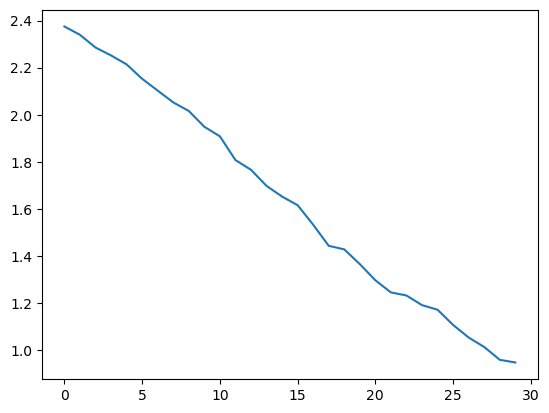

In [57]:
plt.plot(epoch_loss)

In [58]:
def get_new_query_emb(query, adapter_matrix):
    query_emb = torch.Tensor(model.embed_query(query))
    query_emb = torch.matmul(query_emb, torch.Tensor(adapter_matrix))
    norm_emb = torch.nn.functional.normalize(query_emb, dim=-1)
    return norm_emb.numpy()

## 看看在训练集上是不是正例都排到前面去了

In [59]:
def compute_reverse_pairs(lis):
    '''
    计算0在1前面的对数，称为逆序对
    '''
    cnt = 0
    for i in range(len(lis)):
        if lis[i] == 0:
            for j in range(i, len(lis), 1):
                if lis[j] == 1:
                    cnt += 1
    return cnt

def compare_v1(line):
    '''
    获得一个样本召回结果中所有的逆序对数（旧逆序对，新逆序对数）
    '''
    raw = [doc["label"] for doc in line["docs"]]
    raw_cnt = compute_reverse_pairs(raw)
    
    query_emb = get_new_query_emb(line["query"], best_weights)
    
    def get_norm_emb(emb):
        norm = np.linalg.norm(emb)
        return emb / norm
    
    new_docs = [{"new_score": get_norm_emb(doc["doc_emb"] @ best_weights) @ query_emb, "label": doc["label"]} for doc in line["docs"]]
    sorted_docs = sorted(new_docs, reverse=True, key=lambda x: x["new_score"])
    new = [i["label"] for i in sorted_docs]
    new_cnt = compute_reverse_pairs(new)
    return raw_cnt, new_cnt

In [60]:
compare_v1(train[0])

(7, 0)

In [61]:
# 所有样本的逆序数对比
a, b = 0, 0
for row in train:
    i, j = compare_v1(row)
    a += i
    b += j
print(a, b)

443 31


In [62]:
from langchain_core.embeddings import Embeddings


class NewEncoder(Embeddings):
    def embed_documents(self, docs):
        emb = np.array(model.embed_documents(docs)) @ np.array(best_weights)
        norm = np.linalg.norm(emb, axis=1)
        return emb / np.expand_dims(norm, axis=1)
    
    def embed_query(self, query):
        emb = np.array(model.embed_documents(["为这个句子生成表示以用于检索相关文章：" + query])[0]) @ np.array(best_weights)
        norm = np.linalg.norm(emb)
        return emb / norm

In [63]:
new_model = NewEncoder()

## 新的向量数据库！

In [64]:
new_db = encode_with_progress_bar(docs, model=new_model)

enocde docs...:   0%|          | 0/8 [00:00<?, ?it/s]

In [65]:
for qa in tqdm(qa_data, desc="rag_answer"):
    qa["new_knowledge"], qa["new_rag_answer"] = llm_rag_answer(qa["query"], db=new_db, return_knowledge=True)

rag_answer:   0%|          | 0/100 [00:00<?, ?it/s]

In [66]:
for qa in tqdm(qa_data, desc="eval_rag_answer"):
    qa["new_eval_label"] = eval_rag_answer(qa["answer"], qa["new_rag_answer"])

eval_rag_answer:   0%|          | 0/100 [00:00<?, ?it/s]

In [67]:
sum([int(i["new_eval_label"]) for i in qa_data])

40

## 最后再看一眼token消耗

In [68]:
tokens_counter

{'prompt_tokens': 582383, 'completion_tokens': 15804, 'total_tokens': 598187}

In [69]:
for row in qa_data:
    print(row["query"])
    print(row["answer"])
    print(row["rag_answer"], row["eval_label"])
    print(row["new_rag_answer"], row["new_eval_label"])
    print()
    

石猴出生在哪里?
东胜瀛洲傲来国花果山
石猴出生在东胜神洲海东傲来小国的花果山上。 1
石猴出生在花果山。 1

为什么取名孙悟空?
因为是猢狲，取姓为孙，排行第十为悟，取名为悟空
取名孙悟空是因为在祖师的门中有十二个字用来分派起名，孙悟空是第十辈的小徒，对应的字是“悟”。同时，祖师根据猴王的特点，认为他像个食松果的猢狲，故取其姓为“孙”，结合“悟”字，起名为“孙悟空”。后来，菩萨得知他已有此名，且与之前归降的两人同属“悟”字排行，认为相合甚好，便没有另起新名。 1
取名孙悟空是因为在祖师的门中有十二个字分派起名，孙悟空是第十辈的小徒，正当“悟”字。所以给他起个法名叫做“孙悟空”。猴王对此名字非常满意。 0

孙悟空从祖师那里学会了哪些本领?
长生之道，七十二变和筋斗云
孙悟空从祖师那里学会了躲避三灾之法，以及地煞数的变化，共七十二般变化。 1
孙悟空从祖师那里学会了地煞数，即七十二般变化，以及筋斗云的本领。 1

被祖师赶走时，不许他说什么?
不许他说是祖师的徒弟
没有找到答案。 0
没有找到答案。 0

孙悟空的兵器叫什么?有多重?
叫金箍如意棒，重一万三千五百斤
孙悟空的兵器叫如意金箍棒，重一万三千五百斤。 1
孙悟空的兵器叫如意金箍棒，重一万三千五百斤。 1

这兵器原有什么作用?是大禹治水是定江海深浅的定子
这个兵器指的是传说中的定海神针，据说是大禹治水时用来定江海深浅的工具。
这兵器原本的作用是定江海浅深，是大禹治水时的一个定子。 1
这兵器原有什么作用？答案是：大禹治水时用来定江海深浅的定子。 1

弼马温是什么工作?
养马
弼马温是管理天宫马匹的官职。 0
弼马温是管理天马的工作，主要负责滋养马匹，确保马匹健康肥壮。 1

孙悟空在大闹天宫，做了哪些事?
偷吃蟠桃，偷吃御酒，偷吃老君仙丹
孙悟空在大闹天宫时，做了以下事情：首先，他打出南天门，挑战天庭的众神；其次，他偷吃了仙丹，变得法力更为强大；最后，他在天尽头见到五根肉红柱，并在其中一根上留下“齐天大圣，到此一游”的字迹。这些行为最终导致了他被如来佛祖以五指山压住，受到惩罚。 1
孙悟空在大闹天宫时，做了以下事情：偷吃蟠桃园的老树大桃，设计赚哄赤脚大仙变其相貌入会，偷吃仙肴仙酒，偷吃老君仙丹，偷御酒若干，并把这些东西带回花果山与众猴享乐。 1

为什么大闹天宫?
因为蟠桃会没有请他
妖猴孙悟空因为觉

# 10. 我们还能够用GLM4为我们的RAG程序做什么？

1. 当GLM4可以为我们标注数据之后，很多事情都可以做，都可以做到的更好。目前这个rag程序并未包含reranker，我们可以同样微调我们的reranker，而且可以调的更加的精细

2. 使用GLM4去扩展用户query，提高召回，比如扩展query，或者生成fake answer来进行召回

3. GLM4首先是一个极其强大的语言模型，你可以使用它去为你的文本段落构建更加明晰、简单的高效索引来以供检索。也可以通过它关注不同的方面来生成不同类型的索引，支持我们rag程序的多路召回，更好地提供召回能力

4. 多轮对话中的用户语义理解。

5. 直接使用GLM4生成问题数据！通过某个分片或者多个分片让GLM4自动生成问答数据，你可以拥有一个完全从0到1的系统，你需要的只是买token